# Fitting remaining ion current conductances

Using full AP/CaT measures to fit the remaining conductances.

In [1]:
from pyabc import (ABCSMC, Distribution, RV,
                   History, Model,
                   ModelResult, MedianEpsilon)
from pyabc.transition import MultivariateNormalTransition
from pyabc.sampler import MulticoreEvalParallelSampler
from pyabc_custom import MyokitSimulation
from prangle_distance import PrangleDistance, PrangleEpsilon, PranglePopulationSize

import matplotlib.pyplot as plt
import os
import tempfile
import pandas as pd

%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

In [2]:
# Get all ABC channel results.
history = {'icat': History('sqlite:///pyabc-runs/hl-1_icat.db'),
           'ical': History('sqlite:///pyabc-runs/hl-1_ical.db'),
           'ina': History('sqlite:///pyabc-runs/hl-1_ina.db'),
           'ikr': History('sqlite:///pyabc-runs/hl-1_ikr.db'),
           'ikur': History('sqlite:///pyabc-runs/hl-1_ikur.db'),
           'ito': History('sqlite:///pyabc-runs/hl-1_ito.db'),
           'iha': History('sqlite:///pyabc-runs/hl-1_iha.db'),
           'ik1': History('sqlite:///pyabc-runs/hl-1_ik1.db')}

In [3]:
# Set to correct result (last ABC run in database).
for _,h in history.items():
    h.id = len(h.all_runs())

In [4]:
# Generate a sample from all history items.
def generate_sample(history, n):
    samples = [dict() for i in range(n)]
    for k, h in history.items():
        dist = h.get_distribution(m=0)
        weights = dist[1]
        ch_samples = dist[0] \
                    .sample(n, weights=weights, replace=True) \
                    .to_dict(orient='records')
        ch_samples = [{k+'.'+key: value for key, value in ch.items()}
                      for ch in ch_samples]
        for c, s in zip(ch_samples, samples):
            s.update(c)
    return samples

In [5]:
# Generate samples
n_samples = 5000
param_samples = generate_sample(history, n_samples)

/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


In [6]:
def model_measure(result):
    return result.to_dict()['0']

myokit_model = MyokitSimulation('hl1', param_samples, model_measure)

In [53]:
# Test that the model actually produces output
#  -> no sim failure :)
myokit_model.sample({'ik1.g_K1': 4.300043e-02,
                     'incx.k_NCX': 8.104245e-16,
                     'icab.g_Cab': 2.626651e-04,
                     'inab.g_Nab': 8.062469e-04,
                     'inak.i_NaK_max': 4.640682e+00})

{0: -79.640043, 1: 130.08146399999998, 2: 62.389701, 3: 49.250269}

In [8]:
# Targets from Dias, 2014 from HL1-6 myocyte
dias_measurements = {'v_rest': -67,
                     #'ca_i': 0.15,
                     #'na_i': 15000,
                     #'k_i': 130000,
                     'apa': 105,
                     'apd90': 42,
                     'ca_ttp': 52}
obs = dict(zip(range(len(dias_measurements)),
               list(dias_measurements.values())))
exp = dict(zip(range(len(dias_measurements)),
               range(len(dias_measurements))))

In [9]:
limits = {'ik1.g_K1': (0, 0.1),
          'incx.k_NCX': (0, 1e-15),
          'icab.g_Cab': (0, 0.001),
          'inab.g_Nab': (0, 0.01),
          'inak.i_NaK_max': (0, 10)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [10]:
db_path = ("sqlite:////scratch/cph211/hl-1_full.db")

In [11]:
# Let's log this shit
import logging
logging.basicConfig()
abclogger = logging.getLogger("ABC")
abclogger.setLevel(logging.INFO)

In [12]:
abc = ABCSMC(models=myokit_model,
             parameter_priors=prior,
             distance_function=PrangleDistance(exp_map=exp,
                 alpha=0.5,
                 delta=0.5,
                 adapt=False),
             population_size=PranglePopulationSize(800, 0.5,
                 adapt=True,
                 mean_cv=0.4, 
                 min_population_size=200,
                 max_population_size=5000),
             eps=PrangleEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=24))

In [13]:
abc_id = abc.new(db_path, obs)

INFO:Epsilon:initial epsilon is inf
INFO:History:Start <ABCSMC(id=2, start_time=2018-07-29 14:13:25.666562, end_time=None)>


In [14]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

INFO:ABC:t:0 M eps:[inf]
/storage/hhecm/cellrotor/chouston/ion-channel-ABC/prangle_distance.py:102: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = df_weighted.distance.as_matrix()
/storage/hhecm/cellrotor/chouston/ion-channel-ABC/prangle_distance.py:104: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  weights = df_weighted.w.as_matrix()
INFO:ABC:t:0 N eps:50.519670565329484
INFO:ABC:N population size: 800
INFO:ABC:t:1 M eps:[        inf 50.51967057]
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/smc.py

INFO:Adaptation:Change nr particles 200 -> 200
/storage/hhecm/cellrotor/chouston/ion-channel-ABC/prangle_distance.py:102: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = df_weighted.distance.as_matrix()
/storage/hhecm/cellrotor/chouston/ion-channel-ABC/prangle_distance.py:104: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  weights = df_weighted.w.as_matrix()
INFO:ABC:t:7 N eps:5.6788009582656205
INFO:ABC:N population size: 200
INFO:ABC:t:8 M eps:[        inf 50.51967057 29.48721346 18.15334992 13.44515657 10.17231736
  8.18053301  6.80658898  5.67880096]
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future versi

In [16]:
df, w = history.get_distribution(0)
print(df.mean())
print(df.std())

name
icab.g_Cab        4.605495e-04
ik1.g_K1          3.039994e-02
inab.g_Nab        6.113868e-03
inak.i_NaK_max    8.279226e+00
incx.k_NCX        6.333789e-16
dtype: float64
name
icab.g_Cab        2.773748e-04
ik1.g_K1          2.017059e-02
inab.g_Nab        2.166605e-03
inak.i_NaK_max    1.372672e+00
incx.k_NCX        1.700861e-16
dtype: float64


/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


In [17]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

INFO:ABC:t:10 M eps:[        inf 50.51967057 29.48721346 18.15334992 13.44515657 10.17231736
  8.18053301  6.80658898  5.67880096  4.76906619  3.99456878]
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()
/storage/hhecm/cellrotor/chouston/pyabc/pyabc/smc.py:690: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.history.max_t)["p"].as_matrix()
INFO:Adaptation:Change nr particles 200 -> 200
/storage/hhecm/cellrotor/chouston/ion-channel-ABC/prangle_distance.py:102: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = df_weighted.distance.as_matrix()
/stora

KeyboardInterrupt: 

In [22]:
df, w = history.get_distribution(m=0)

/storage/hhecm/cellrotor/chouston/pyabc/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


In [23]:
df.mean()

name
icab.g_Cab        5.017593e-04
ik1.g_K1          2.794481e-02
inab.g_Nab        6.540387e-03
inak.i_NaK_max    7.363952e+00
incx.k_NCX        6.356384e-16
dtype: float64

In [26]:
myokit_model.sample({'ik1.g_K1': 2.794481e-02,
                     'incx.k_NCX': 6.356384e-16,
                     'icab.g_Cab': 5.017593e-04,
                     'inab.g_Nab': 6.540387e-03,
                     'inak.i_NaK_max': 7.363952e+00})

{0: -51.030118, 1: 95.340339, 2: 43.58866, 3: 48.028726}

/storage/hhecm/cellrotor/chouston/pyabc/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()


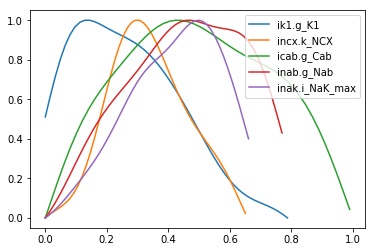

In [52]:
from pyabc.visualization import kde_1d
for ch in limits.keys():
    x, pdf = kde_1d(df, w, ch)
    pdf_n = (pdf-min(pdf))/(max(pdf)-min(pdf))
    x_n = (x-min(x))/(limits[ch][1]-limits[ch][0])
    plt.plot(x_n, pdf_n, label=ch)
plt.legend()

## Plot sample of voltage traces

In [22]:
# Manual settings
for sample in param_samples:
    sample['ik1.g_K1'] = 2.108099e-02 #0.024 produced appropriate levels for Ca_i and Na_i
    sample['incx.k_NCX'] = 6.487460e-16#2.268e-16
    sample['icab.g_Cab'] = 5.131545e-04#0.0008
    sample['inab.g_Nab'] = 5.466241e-03
    sample['inak.i_NaK_max'] = 8.424755e+00

In [ ]:
from pyabc_custom import simulate
import seaborn as sns
import numpy as np
import pandas as pd

output_samples = pd.DataFrame()
n_failures = 0
for i, sample in enumerate(param_samples):
    try:
        output = simulate('hl1', exp_num=0, **sample)
    except:
        n_failures = n_failures + 1
        continue
    output['sample'] = i
    output_samples = output_samples.append(output,
                                           ignore_index=True)
print('There were ' + str(n_failures) + ' failed simulations.')

In [11]:
np.mean(output_samples.iloc[range(4,len(output_samples),5)]['0'])
output_samples

,0,exp,sample
0,-62.527795,1,0
1,77.690835,1,0
2,15.163040,1,0
3,106.822245,1,0
4,143.193779,1,0
5,-70.669496,1,1
6,1.447346,1,1
7,-69.222150,1,1
8,1000.000000,1,1
9,0.000000,1,1


In [10]:
sns.set_context('paper')
sns.set_style('white')

y_var = 'membrane.V'

grid = sns.lineplot(data=output_samples,
                    x="environment.time", y=y_var,
                    #units="sample", 
                    estimator=np.mean, 
                    err_style="band", ci="sd",
                    color="black")
grid.set_xlabel('time, ms')
grid.set_ylabel('variable, AU')
for l in grid.axes.lines:
    l.set_linestyle('--')
plt.tight_layout()
#plt.savefig('pulse_train_Ca.pdf', format='pdf', dpi=1000)

final_time = max(output_samples['environment.time'])

print('Variable: ' + y_var)
men = np.mean(output_samples[output_samples['environment.time']==final_time][y_var])
print('Mean: ' + str(men))
sd = np.std(output_samples[output_samples['environment.time']==final_time][y_var])
print('Standard Deviation: ' + str(sd))
med = np.median(output_samples[output_samples['environment.time']==final_time][y_var])
print('Median: ' + str(med))
perc = np.percentile(output_samples[output_samples['environment.time']==final_time][y_var], [75,25])
print('Interquartile range: ' + str(perc[0]-perc[1]))

ValueError: Could not interpret input 'environment.time'

In [7]:
# Manual settings
for sample in param_samples:
    sample['ik1.g_K1'] = 0.024 #0.024 produced appropriate levels for Ca_i and Na_i
    sample['incx.k_NCX'] = 5e-16#2.268e-16
    sample['icab.g_Cab'] = 0.0001#0.0008
    sample['inab.g_Nab'] = 0.005
    sample['inak.i_NaK_max'] = 4